In [1]:
include("../test/bilayernetworks.jl")

(CSet(
  T = 1:3,
  S = 1:4,
  I = 1:4,
  O = 1:4,
  it : I → T = [1, 1, 2, 3],
  is : I → S = [1, 2, 3, 2],
  ot : O → T = [1, 1, 2, 3],
  os : O → S = [3, 2, 2, 4]), CSet(
  T = 1:3,
  S = 1:4,
  I = 1:4,
  O = 1:4,
  it : I → T = [1, 1, 2, 3],
  is : I → S = [1, 2, 3, 2],
  ot : O → T = [1, 1, 2, 3],
  os : O → S = [3, 2, 2, 4]))

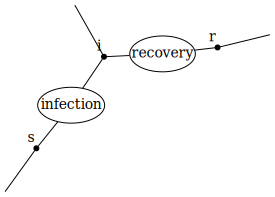

In [2]:
display_uwd(sir)

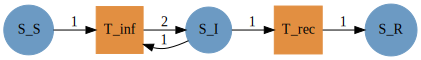

In [3]:
Graph(psir)

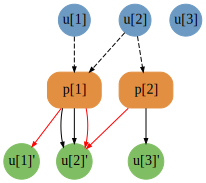

In [4]:
to_graphviz(bnsir)

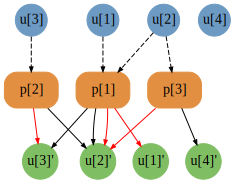

In [5]:
to_graphviz(bnseir)

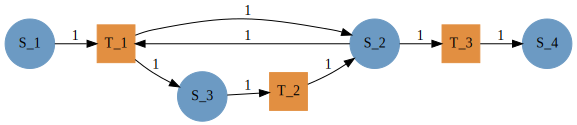

In [6]:
Graph(bnrt)

![Quarantine Model](../docs/src/assets/quarantine_model.png)

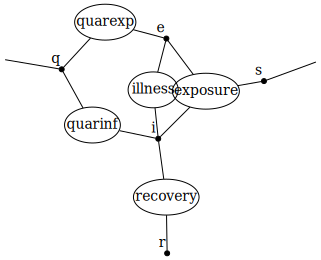

In [7]:
qm = @relation (s,q) begin
    exposure(s,i,e)
    illness(e,i)
    recovery(i,r)
    quarexp(e,q)
    quarinf(i,q)
end
display_uwd(qm)

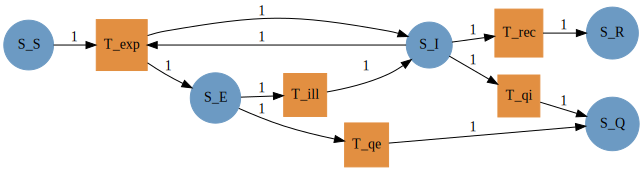

In [8]:
import AlgebraicPetri.Epidemiology: exposure_petri, spontaneous_petri
semantics = Dict(
    :infection => exposure_petri(:S, :I, :I, :inf),
    :exposure  => exposure_petri(:S, :I, :E, :exp),
    :illness   => spontaneous_petri(:E,:I,:ill),
    :recovery  => spontaneous_petri(:I,:R,:rec),
    :death     => spontaneous_petri(:I,:D,:death),
    :quarexp   => spontaneous_petri(:E, :Q, :qe),
    :quarinf   => spontaneous_petri(:I, :Q, :qi),
    :quarrec   => spontaneous_petri(:Q, :R, :qr)
)
pn_quar = oapply(qm, semantics)  |> apex
Graph(pn_quar)

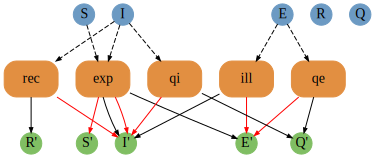

In [9]:
bnquar = LabelledBilayerNetwork()
migrate!(bnquar, pn_quar)
to_graphviz(bnquar)

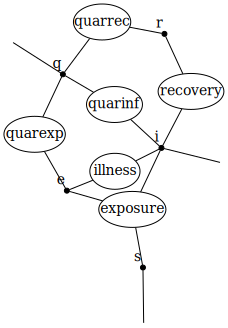

In [10]:
qm = @relation (s,i,q) begin
    exposure(s,i,e)
    illness(e,i)
    recovery(i,r)
    quarexp(e,q)
    quarinf(i,q)
    quarrec(q,r)
end
display_uwd(qm)

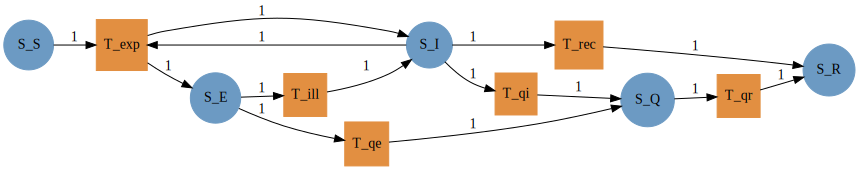

In [11]:
pn_quar = oapply(qm, semantics)  |> apex
Graph(pn_quar)

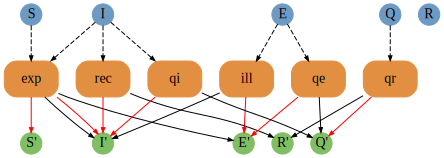

In [12]:
bnquar = LabelledBilayerNetwork()
migrate!(bnquar, pn_quar)
to_graphviz(bnquar)

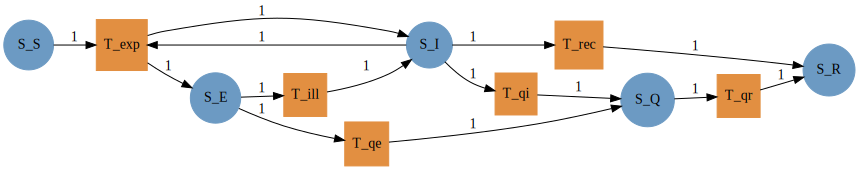

In [13]:
quarrt = LabelledPetriNet()
migrate!(quarrt, bnquar) |> Graph

In [14]:
bnquar

Qin,variable
1,S
2,I
3,E
4,R
5,Q
Qout,tanvar
1,S
2,I
3,E
4,R


In [15]:
function evaluate!(du, ϕ, bn::AbstractLabelledBilayerNetwork, state; params...)
    du.= 0.0
    ϕ .= 1.0
    for i in parts(bn, :Win)
        ϕ[bn[i, :call]] *= state[bn[i, :arg]]
    end
    for i in parts(bn, :Box)
        ϕ[i] *= params[bn[i, :parameter]]
    end
    
    for i in parts(bn, :Wn)
        du[bn[i, :effusion]] -= ϕ[bn[i, :efflux]]
    end
    for i in parts(bn, :Wa)
        du[bn[i, :infusion]] += ϕ[bn[i, :influx]]
    end
    return du
end

evaluate(bn::AbstractLabelledBilayerNetwork, state; params...) = evaluate!(zeros(length(state)), ones(nparts(bn, :Box)), bn, state; params...)


evaluate (generic function with 1 method)

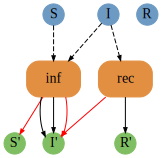

In [16]:
bnsir = LabelledBilayerNetwork()
migrate!(bnsir, psir)
bnsir

to_graphviz(bnsir)

In [17]:
evaluate(bnsir, [10, 1, 0.0], inf=0.1, rec=0.3)

3-element Array{Float64,1}:
 -1.0
  0.7
  0.3

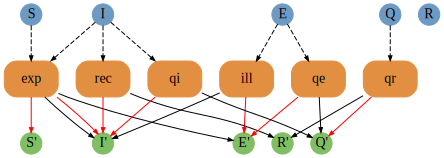

In [18]:
to_graphviz(bnquar)

In [19]:
evaluate(bnquar, [10.0, 1, 0, 0,0,0], exp=0.1, rec=0.3, qi=0.2, ill=0.7, qe=0.23, qr=0.3)

6-element Array{Float64,1}:
 -1.0
 -0.5
  1.0
  0.3
  0.2
  0.0

In [20]:
function euler(bn::AbstractLabelledBilayerNetwork, state, nsteps::Integer, stepsize::Real; params...)
    #preallocate storage so that each step is nonallocating
    du = zeros(length(state))
    ϕ = ones(nparts(bn, :Box))
    u = tuple(state...)
    # create a storage space for steps of euler's method
    # store intermediate states as named tuples so that you can integrate
    # with julia Tables.jl data analysis ecosystem
    results = Vector{NamedTuple{tuple(bn[:,:variable]...)}}()
    for i in 1:nsteps
        u = u .+ stepsize.*evaluate!(du, ϕ, bn, u; params...)
        push!(results, NamedTuple{tuple(bn[:,:variable]...)}(u))
    end
    return results
end

euler (generic function with 1 method)

In [21]:
using PrettyTables
function printsoln(bn::AbstractLabelledBilayerNetwork, soln::Vector)
    pretty_table(soln)
end

printsoln (generic function with 1 method)

In [22]:
soln = euler(bnquar, (S=10.0, I=1, E=0, R=0, Q=0), 30, 0.15, exp=0.1, rec=0.03, qi=0.37, ill=0.7, qe=0.23, qr=0.03)
printsoln(bnquar, soln)

┌─────────┬──────────┬──────────┬────────────┬──────────┐
│       S │        I │        E │          R │        Q │
├─────────┼──────────┼──────────┼────────────┼──────────┤
│    9.85 │     0.94 │     0.15 │     0.0045 │   0.0555 │
│ 9.71111 │  0.89935 │  0.26796 │ 0.00897975 │ 0.112595 │
│ 9.58011 │ 0.873525 │ 0.361585 │  0.0135335 │ 0.171247 │
│ 9.45458 │  0.85908 │ 0.436671 │   0.018235 │ 0.231432 │
│ 9.33275 │ 0.853385 │ 0.497589 │  0.0231423 │ 0.293134 │
│ 9.21328 │ 0.854429 │ 0.547642 │  0.0283016 │ 0.356345 │
│  9.0952 │ 0.860666 │ 0.589327 │  0.0337501 │ 0.421056 │
│ 8.97778 │ 0.870905 │ 0.624535 │  0.0395178 │  0.48726 │
│  8.8605 │ 0.884227 │ 0.654694 │  0.0456296 │ 0.554949 │
│ 8.74298 │ 0.899916 │ 0.680885 │  0.0521059 │ 0.624113 │
│ 8.62496 │ 0.917414 │ 0.703921 │   0.058964 │ 0.694741 │
│ 8.50627 │ 0.936281 │ 0.724414 │  0.0662187 │ 0.766816 │
│ 8.38681 │ 0.956168 │ 0.742822 │  0.0738826 │ 0.840321 │
│ 8.26652 │ 0.976794 │ 0.759486 │  0.0819668 │ 0.915234 │
│  8.1454 │ 0.

In [23]:
function paramexps(bn::AbstractLabelledBilayerNetwork, params::Symbol)
    map(parts(bn, :Box)) do i
        p = bn[i, :parameter]
        :(ϕ[$i] *= params[$p])
    end
end

function paramexps(bn::AbstractLabelledBilayerNetwork, params)
    map(parts(bn, :Box)) do i
        p = bn[i, :parameter]
        β = params[p]
        :(ϕ[$i] *= $β)
    end
end

funcwrap(du, ϕ, state, params::Symbol, body::Expr) = :(f!($du, $ϕ, $state, $params, t) = $body)
funcwrap(du, ϕ, state, params, body::Expr) = :(f!($du, $ϕ, $state, t) = $body)


function compile(bn::Union{AbstractLabelledBilayerNetwork, AbstractBilayerNetwork}, du::Symbol, ϕ::Symbol, state::Symbol, params)
    body = quote 
        $du.= 0.0
        $ϕ .= 1.0
    end
    
    ϕs = map(parts(bn, :Win)) do i
        j = bn[i, :arg]
        k = bn[i, :call]
        :(ϕ[$k] *= $state[$j])
    end
    append!(body.args, ϕs)
    ps = paramexps(bn, params)
    append!(body.args, ps)
    
    effs = map(parts(bn, :Wn)) do i
        j = bn[i, :efflux]
        k = bn[i, :effusion]
        :(du[$k] -= ϕ[$j])
    end
    append!(body.args, effs)
    
    infs = map(parts(bn, :Wa)) do i 
        j = bn[i,:influx]
        k = bn[i,:infusion]
        :(du[$k] += ϕ[$j])
    end
    append!(body.args, infs)
    push!(body.args, :(return $du))
    return funcwrap(du, ϕ, state, params, body)
end

compile(bn, du, ϕ, state; params...) = compile(bn, du, ϕ, state, params)

compile (generic function with 2 methods)

In [24]:
compile(bnquar, :du, :ϕ, :u, :p)

:(f!(du, ϕ, u, p, t) = begin
          #= In[23]:16 =#
          begin
              #= In[23]:22 =#
              du .= 0.0
              #= In[23]:23 =#
              ϕ .= 1.0
              ϕ[1] *= u[1]
              ϕ[1] *= u[2]
              ϕ[2] *= u[3]
              ϕ[3] *= u[2]
              ϕ[4] *= u[3]
              ϕ[5] *= u[2]
              ϕ[6] *= u[5]
              ϕ[1] *= params[exp]
              ϕ[2] *= params[ill]
              ϕ[3] *= params[rec]
              ϕ[4] *= params[qe]
              ϕ[5] *= params[qi]
              ϕ[6] *= params[qr]
              du[1] -= ϕ[1]
              du[2] -= ϕ[1]
              du[3] -= ϕ[2]
              du[2] -= ϕ[3]
              du[3] -= ϕ[4]
              du[2] -= ϕ[5]
              du[5] -= ϕ[6]
              du[3] += ϕ[1]
              du[2] += ϕ[1]
              du[2] += ϕ[2]
              du[4] += ϕ[3]
              du[5] += ϕ[4]
              du[5] += ϕ[5]
              du[4] += ϕ[6]
              return du
          end
  

In [25]:
compile(bnquar, :du, :ϕ, :u, exp=0.1, rec=0.03, qi=0.37, ill=0.7, qe=0.23, qr=0.03)

:(f!(du, ϕ, u, t) = begin
          #= In[23]:17 =#
          begin
              #= In[23]:22 =#
              du .= 0.0
              #= In[23]:23 =#
              ϕ .= 1.0
              ϕ[1] *= u[1]
              ϕ[1] *= u[2]
              ϕ[2] *= u[3]
              ϕ[3] *= u[2]
              ϕ[4] *= u[3]
              ϕ[5] *= u[2]
              ϕ[6] *= u[5]
              ϕ[1] *= 0.1
              ϕ[2] *= 0.7
              ϕ[3] *= 0.03
              ϕ[4] *= 0.23
              ϕ[5] *= 0.37
              ϕ[6] *= 0.03
              du[1] -= ϕ[1]
              du[2] -= ϕ[1]
              du[3] -= ϕ[2]
              du[2] -= ϕ[3]
              du[3] -= ϕ[4]
              du[2] -= ϕ[5]
              du[5] -= ϕ[6]
              du[3] += ϕ[1]
              du[2] += ϕ[1]
              du[2] += ϕ[2]
              du[4] += ϕ[3]
              du[5] += ϕ[4]
              du[5] += ϕ[5]
              du[4] += ϕ[6]
              return du
          end
      end)

In [26]:
function eulers(bn::AbstractLabelledBilayerNetwork, funcname::Symbol; params...)
    f = compile(bn, :du, :ϕ, :u; params...)
    varnames = tuple(bn[:,:variable]...)
    nϕ = nparts(bn, :Box)
    quote
    function $funcname(state, nsteps::Integer, stepsize::Real)
        $f
        #preallocate storage so that each step is nonallocating
        du = zeros(length(state))
        ϕ = ones($nϕ)
        u = tuple(state...)
        # create a storage space for steps of euler's method
        # store intermediate states as named tuples so that you can integrate
        # with julia Tables.jl data analysis ecosystem
        results = Vector{NamedTuple{$varnames}}()
        for i in 1:nsteps
            Δ = f!(du, ϕ, u, 0)
            u = u .+ stepsize.*Δ
            push!(results, NamedTuple{$varnames}(u))
        end
        return results
    end 
    end
end

eulers (generic function with 1 method)

In [27]:
eulers(bnsir, :eulsir, inf=0.3, rec=0.2)

quote
    #= In[26]:6 =#
    function eulsir(state, nsteps::Integer, stepsize::Real)
        #= In[26]:6 =#
        #= In[26]:7 =#
        f!(du, ϕ, u, t) = begin
                #= In[23]:17 =#
                begin
                    #= In[23]:22 =#
                    du .= 0.0
                    #= In[23]:23 =#
                    ϕ .= 1.0
                    ϕ[1] *= u[1]
                    ϕ[1] *= u[2]
                    ϕ[2] *= u[2]
                    ϕ[1] *= 0.3
                    ϕ[2] *= 0.2
                    du[1] -= ϕ[1]
                    du[2] -= ϕ[1]
                    du[2] -= ϕ[2]
                    du[2] += ϕ[1]
                    du[2] += ϕ[1]
                    du[3] += ϕ[2]
                    return du
                end
            end
        #= In[26]:9 =#
        du = zeros(length(state))
        #= In[26]:10 =#
        ϕ = ones(2)
        #= In[26]:11 =#
        u = tuple(state...)
        #= In[26]:15 =#
        results = Vector{NamedTuple{(:S, :

In [28]:
eulseirqexp = eulers(bnquar, :eulseirq, exp=0.1, rec=0.03, qi=0.37, ill=0.7, qe=0.23, qr=0.03)

quote
    #= In[26]:6 =#
    function eulseirq(state, nsteps::Integer, stepsize::Real)
        #= In[26]:6 =#
        #= In[26]:7 =#
        f!(du, ϕ, u, t) = begin
                #= In[23]:17 =#
                begin
                    #= In[23]:22 =#
                    du .= 0.0
                    #= In[23]:23 =#
                    ϕ .= 1.0
                    ϕ[1] *= u[1]
                    ϕ[1] *= u[2]
                    ϕ[2] *= u[3]
                    ϕ[3] *= u[2]
                    ϕ[4] *= u[3]
                    ϕ[5] *= u[2]
                    ϕ[6] *= u[5]
                    ϕ[1] *= 0.1
                    ϕ[2] *= 0.7
                    ϕ[3] *= 0.03
                    ϕ[4] *= 0.23
                    ϕ[5] *= 0.37
                    ϕ[6] *= 0.03
                    du[1] -= ϕ[1]
                    du[2] -= ϕ[1]
                    du[3] -= ϕ[2]
                    du[2] -= ϕ[3]
                    du[3] -= ϕ[4]
                    du[2] -= ϕ[5]
                   

In [29]:
eulsirexp = eulers(bnsir, :eulsir, inf=0.3, rec=0.2)

quote
    #= In[26]:6 =#
    function eulsir(state, nsteps::Integer, stepsize::Real)
        #= In[26]:6 =#
        #= In[26]:7 =#
        f!(du, ϕ, u, t) = begin
                #= In[23]:17 =#
                begin
                    #= In[23]:22 =#
                    du .= 0.0
                    #= In[23]:23 =#
                    ϕ .= 1.0
                    ϕ[1] *= u[1]
                    ϕ[1] *= u[2]
                    ϕ[2] *= u[2]
                    ϕ[1] *= 0.3
                    ϕ[2] *= 0.2
                    du[1] -= ϕ[1]
                    du[2] -= ϕ[1]
                    du[2] -= ϕ[2]
                    du[2] += ϕ[1]
                    du[2] += ϕ[1]
                    du[3] += ϕ[2]
                    return du
                end
            end
        #= In[26]:9 =#
        du = zeros(length(state))
        #= In[26]:10 =#
        ϕ = ones(2)
        #= In[26]:11 =#
        u = tuple(state...)
        #= In[26]:15 =#
        results = Vector{NamedTuple{(:S, :

In [30]:
eval(eulsirexp)
soln_codegen = eulsir((S=10.0, I=1, R=0), 30, 0.15)
pretty_table(soln_codegen)

┌─────────────┬─────────┬──────────┐
│           S │       I │        R │
├─────────────┼─────────┼──────────┤
│        9.55 │    1.42 │     0.03 │
│     8.93976 │ 1.98764 │   0.0726 │
│     8.14015 │ 2.72762 │ 0.132229 │
│       7.141 │ 3.64494 │ 0.214058 │
│     5.96972 │ 4.70688 │ 0.323406 │
│     4.70527 │ 5.83011 │ 0.464613 │
│     3.47082 │ 6.88966 │ 0.639516 │
│     2.39475 │ 7.75905 │ 0.846206 │
│      1.5586 │ 8.36242 │  1.07898 │
│    0.972087 │ 8.69806 │  1.32985 │
│      0.5916 │ 8.81761 │  1.59079 │
│    0.356858 │ 8.78782 │  1.85532 │
│    0.215737 │ 8.66531 │  2.11895 │
│    0.131613 │ 8.48947 │  2.37891 │
│   0.0813334 │ 8.28507 │   2.6336 │
│     0.05101 │ 8.06684 │  2.88215 │
│    0.032493 │ 7.84335 │  3.12416 │
│   0.0210246 │ 7.61952 │  3.35946 │
│   0.0138157 │ 7.39814 │  3.58804 │
│  0.00921622 │  7.1808 │  3.80999 │
│  0.00623813 │ 6.96835 │  4.02541 │
│    0.004282 │ 6.76126 │  4.23446 │
│  0.00297918 │ 6.55972 │   4.4373 │
│  0.00209976 │ 6.36381 │  4.63409 │
│

In [31]:
eval(eulseirqexp)
soln_codegen = eulseirq((S=10.0, I=1, E=0, R=0, Q=0), 30, 0.15)
pretty_table(soln_codegen)

┌─────────┬──────────┬──────────┬────────────┬──────────┐
│       S │        I │        E │          R │        Q │
├─────────┼──────────┼──────────┼────────────┼──────────┤
│    9.85 │     0.94 │     0.15 │     0.0045 │   0.0555 │
│ 9.71111 │  0.89935 │  0.26796 │ 0.00897975 │ 0.112595 │
│ 9.58011 │ 0.873525 │ 0.361585 │  0.0135335 │ 0.171247 │
│ 9.45458 │  0.85908 │ 0.436671 │   0.018235 │ 0.231432 │
│ 9.33275 │ 0.853385 │ 0.497589 │  0.0231423 │ 0.293134 │
│ 9.21328 │ 0.854429 │ 0.547642 │  0.0283016 │ 0.356345 │
│  9.0952 │ 0.860666 │ 0.589327 │  0.0337501 │ 0.421056 │
│ 8.97778 │ 0.870905 │ 0.624535 │  0.0395178 │  0.48726 │
│  8.8605 │ 0.884227 │ 0.654694 │  0.0456296 │ 0.554949 │
│ 8.74298 │ 0.899916 │ 0.680885 │  0.0521059 │ 0.624113 │
│ 8.62496 │ 0.917414 │ 0.703921 │   0.058964 │ 0.694741 │
│ 8.50627 │ 0.936281 │ 0.724414 │  0.0662187 │ 0.766816 │
│ 8.38681 │ 0.956168 │ 0.742822 │  0.0738826 │ 0.840321 │
│ 8.26652 │ 0.976794 │ 0.759486 │  0.0819668 │ 0.915234 │
│  8.1454 │ 0.

In [32]:
make_reflexive!(pn::AbstractPetriNet) = begin
    for s in parts(pn, :S)
        t = add_transition!(pn)
        add_input!(pn, t, s)
        add_output!(pn, t, s)
    end
    return pn
end
reflexivepetri(X) = begin
    pn = PetriNet()
    copy_parts!(pn, X)
    make_reflexive!(pn)
    return pn
end

forget_labels(lpn::AbstractLabelledPetriNet) = begin
    pn = PetriNet()
    copy_parts!(pn, lpn)
    return pn
end

forget_labels(lpn) = forget_labels(apex(lpn))

forget_labels (generic function with 2 methods)

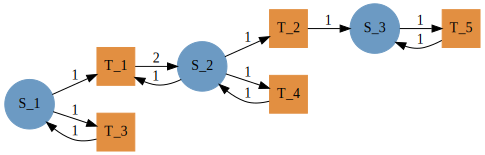

In [33]:
sir_unlabelled = reflexivepetri(forget_labels(psir))
Graph(sir_unlabelled)

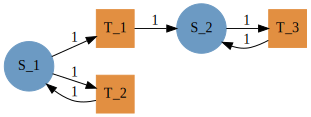

In [34]:
twostep = reflexivepetri(forget_labels(spontaneous_petri(:A, :B, :transport)))
Graph(twostep)

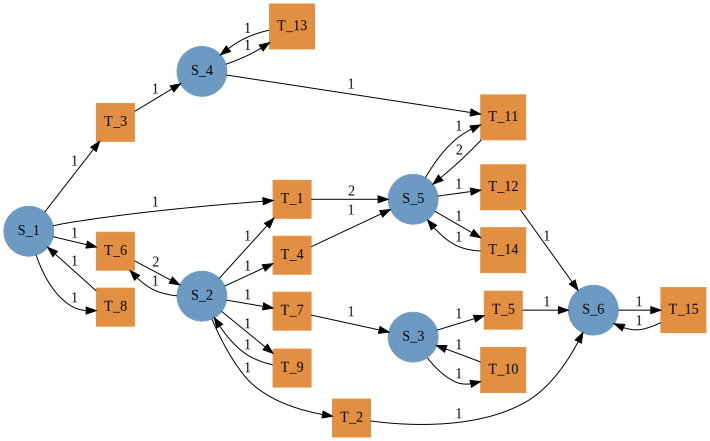

In [35]:
sir² = product(sir_unlabelled, twostep) |> apex
Graph(sir²)

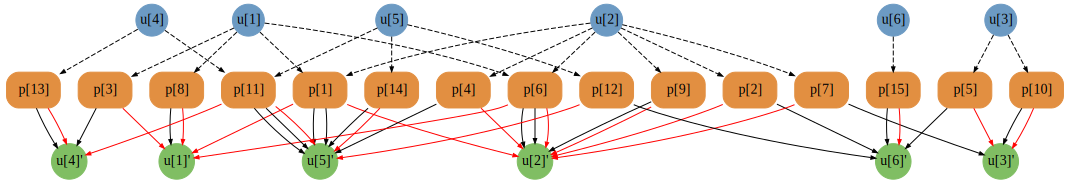

In [36]:
bnsir² = BilayerNetwork()
migrate!(bnsir², sir²)
to_graphviz(bnsir²)

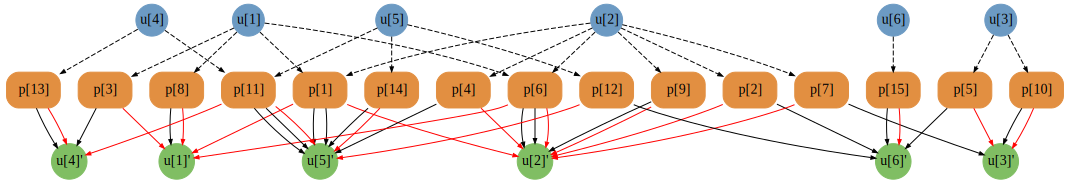

In [37]:
bntwostep = BilayerNetwork()
migrate!(bntwostep, twostep)
bnsir_unlabelled = BilayerNetwork()
migrate!(bnsir_unlabelled, sir_unlabelled)
product(bnsir_unlabelled, bntwostep) |> apex |> to_graphviz

In [38]:
function paramexps(bn::AbstractBilayerNetwork, params::Symbol)
    map(parts(bn, :Box)) do p
        :(ϕ[$p] *= params[$p])
    end
end

paramexps (generic function with 3 methods)

In [39]:
product(bnsir_unlabelled, bntwostep) |> apex |> x->compile(x, :du, :ϕ, :u, :params)

:(f!(du, ϕ, u, params, t) = begin
          #= In[23]:16 =#
          begin
              #= In[23]:22 =#
              du .= 0.0
              #= In[23]:23 =#
              ϕ .= 1.0
              ϕ[1] *= u[1]
              ϕ[1] *= u[2]
              ϕ[2] *= u[2]
              ϕ[3] *= u[1]
              ϕ[4] *= u[2]
              ϕ[5] *= u[3]
              ϕ[6] *= u[1]
              ϕ[6] *= u[2]
              ϕ[7] *= u[2]
              ϕ[8] *= u[1]
              ϕ[9] *= u[2]
              ϕ[10] *= u[3]
              ϕ[11] *= u[4]
              ϕ[11] *= u[5]
              ϕ[12] *= u[5]
              ϕ[13] *= u[4]
              ϕ[14] *= u[5]
              ϕ[15] *= u[6]
              ϕ[1] *= params[1]
              ϕ[2] *= params[2]
              ϕ[3] *= params[3]
              ϕ[4] *= params[4]
              ϕ[5] *= params[5]
              ϕ[6] *= params[6]
              ϕ[7] *= params[7]
              ϕ[8] *= params[8]
              ϕ[9] *= params[9]
              ϕ[10] *= params[10]
  

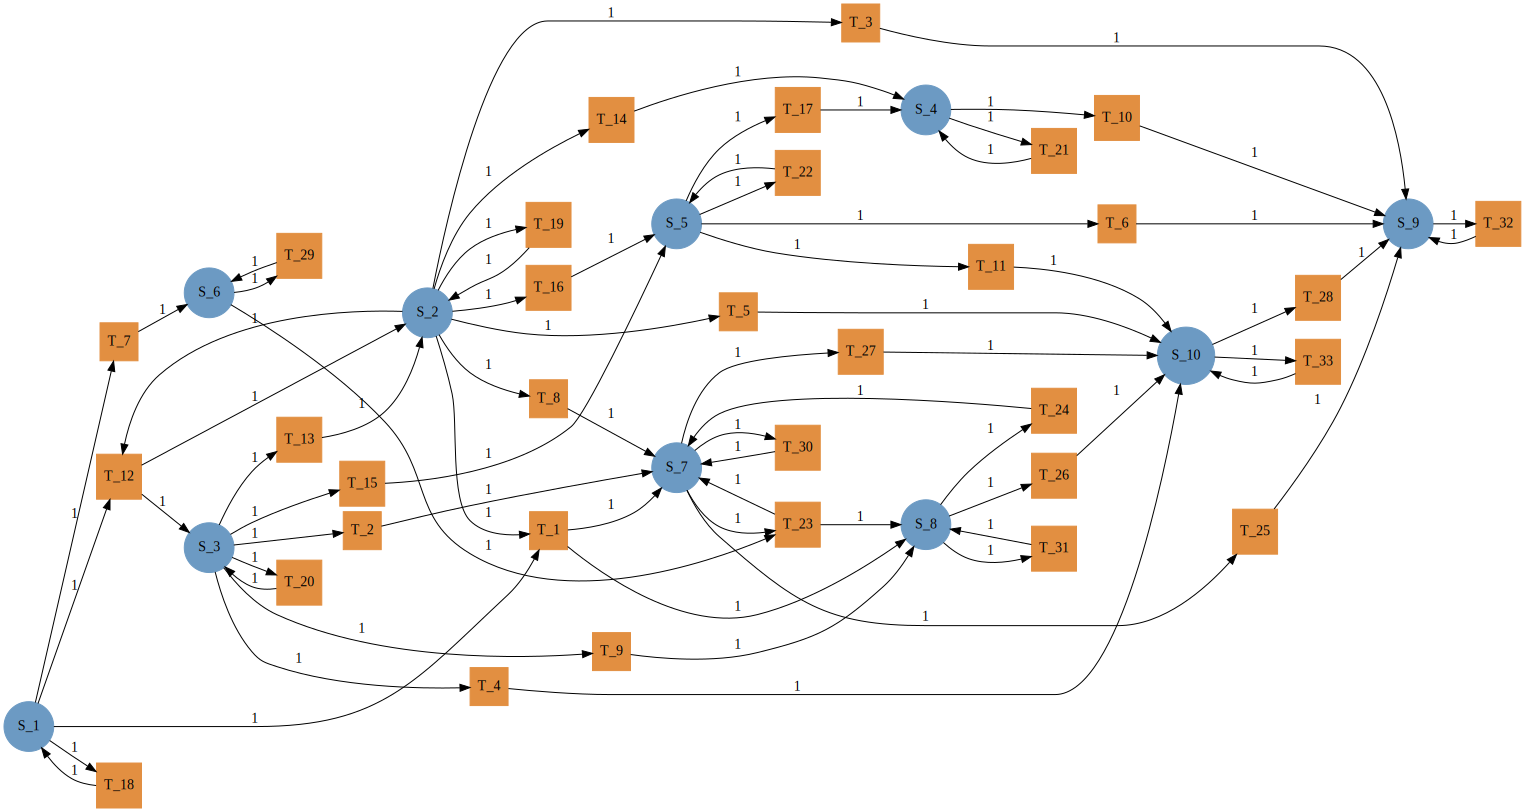

In [40]:
seirq_unlabelled = reflexivepetri(forget_labels(quarrt))
seirq² = product(seirq_unlabelled, twostep) |> apex
Graph(seirq²)

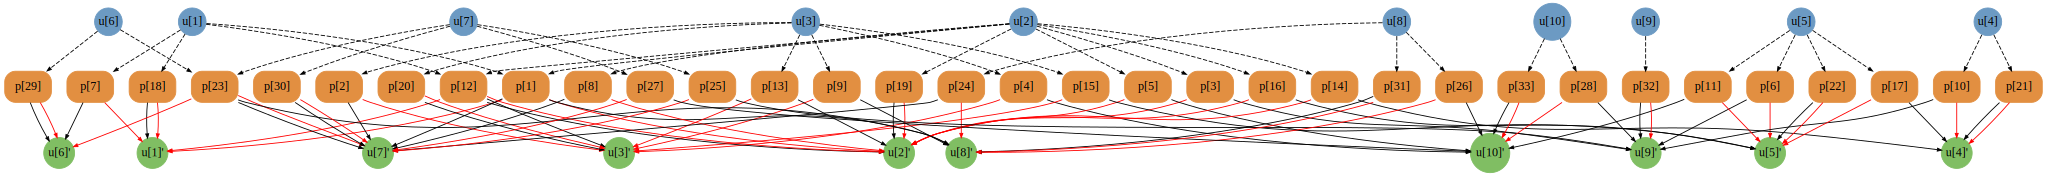

In [41]:
bnseirq² = BilayerNetwork()
migrate!(bnseirq², seirq²)
to_graphviz(bnseirq²)

In [42]:
compile(bnseirq², :du, :ϕ, :u, :params)

:(f!(du, ϕ, u, params, t) = begin
          #= In[23]:16 =#
          begin
              #= In[23]:22 =#
              du .= 0.0
              #= In[23]:23 =#
              ϕ .= 1.0
              ϕ[1] *= u[1]
              ϕ[1] *= u[2]
              ϕ[2] *= u[3]
              ϕ[3] *= u[2]
              ϕ[4] *= u[3]
              ϕ[5] *= u[2]
              ϕ[6] *= u[5]
              ϕ[7] *= u[1]
              ϕ[8] *= u[2]
              ϕ[9] *= u[3]
              ϕ[10] *= u[4]
              ϕ[11] *= u[5]
              ϕ[12] *= u[1]
              ϕ[12] *= u[2]
              ϕ[13] *= u[3]
              ϕ[14] *= u[2]
              ϕ[15] *= u[3]
              ϕ[16] *= u[2]
              ϕ[17] *= u[5]
              ϕ[18] *= u[1]
              ϕ[19] *= u[2]
              ϕ[20] *= u[3]
              ϕ[21] *= u[4]
              ϕ[22] *= u[5]
              ϕ[23] *= u[6]
              ϕ[23] *= u[7]
              ϕ[24] *= u[8]
              ϕ[25] *= u[7]
              ϕ[26] *= u[8]
              ϕ

In [43]:
product(bnsir_unlabelled, bntwostep) |>
  apex|> to_graphviz |>
  g -> Catlab.Graphics.Graphviz.run_graphviz(stdout, g, format="dot")

digraph G {
	graph [bb="0,0,1062,175.88",
		rankdir=TB
	];
	node [height=0.05,
		label="\N",
		margin=0,
		shape=circle,
		width=0.05
	];
	edge [arrowsize=0.5];
	n1	[color="#E28F41",
		fixedsize=true,
		height=0.5,
		label="p[1]",
		pos="315,89.355",
		shape=rectangle,
		style="rounded, filled",
		width=0.75];
	n22	[color="#80BE63",
		height=0.49105,
		label="u[1]'",
		pos="171,17.678",
		style=filled,
		width=0.49105];
	n1 -> n22	[color=red,
		pos="e,186.82,26.335 287.91,75.25 259.84,61.667 216.61,40.745 191.33,28.514"];
	n23	[color="#80BE63",
		height=0.49105,
		label="u[2]'",
		pos="531,17.678",
		style=filled,
		width=0.49105];
	n1 -> n23	[color=red,
		pos="e,513.83,22.747 342.33,74.911 345.23,73.646 348.16,72.435 351,71.355 406.48,50.287 474.19,32.518 508.6,24.029"];
	n26	[color="#80BE63",
		height=0.49105,
		label="u[5]'",
		pos="315,17.678",
		style=filled,
		width=0.49105];
	n1 -> n26	[color=black,
		pos="e,309.21,34.748 309.08,71.132 308.1,61.66 307.99,49.831 308.74,39.805"];


In [44]:
Catlab.Graphics.Graphviz.run_graphviz(stdout, to_graphviz(bnsir), format="dot")

digraph G {
	graph [bb="0,0,154.21,150.43",
		rankdir=TB
	];
	node [height=0.05,
		label="\N",
		margin=0,
		shape=circle,
		width=0.05
	];
	edge [arrowsize=0.5];
	n1	[color="#E28F41",
		fixedsize=true,
		height=0.5,
		label=inf,
		pos="49.607,75.213",
		shape=rectangle,
		style="rounded, filled",
		width=0.75];
	n6	[color="#80BE63",
		height=0.29463,
		label="S'",
		pos="10.607,10.607",
		style=filled,
		width=0.29463];
	n1 -> n6	[color=red,
		pos="e,15.876,20.066 38.95,57.106 32.515,46.776 24.45,33.83 18.571,24.391"];
	n7	[color="#80BE63",
		height=0.29463,
		label="I'",
		pos="49.607,10.607",
		style=filled,
		width=0.29463];
	n1 -> n7	[color=black,
		pos="e,41.306,17.511 37.425,57.106 35.211,45.986 35.786,31.835 39.15,22.291"];
	n1 -> n7	[color=black,
		pos="e,49.607,21.475 49.607,57.106 49.607,47.542 49.607,35.736 49.607,26.546"];
	n1 -> n7	[color=red,
		pos="e,57.907,17.511 61.788,57.106 64.003,45.986 63.428,31.835 60.063,22.291"];
	n2	[color="#E28F41",
		fixedsize=true,
		height